## Домашнее задание

1. Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ
2. Обучить модель на выбор из [segmentation_models_pytorch](https://segmentation-modelspytorch.readthedocs.io/en/latest/index.html)


**Description.**

The provided dataset is the result of the experiment aimed to replace manual image tagging with automated logic.
More experiments can be found on the Youtube and Telegram channels

The data was gathered and annotated with the custom semisupervised image annotation algorithm. It took about 6 hours to prepare whole dataset and only 1 hour to configure framework (the only manual operation in the flow).

In [1]:
# Установить библиотеку, если она еще не установлена. 

# !pip install segmentation-models-pytorch

In [2]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms

import segmentation_models_pytorch as smp
import torchvision.transforms.functional as TF
from tqdm import tqdm

### 1. Загрузим датасет. 

In [3]:
DATA_ROOT = './set-lipstick-original/'

In [4]:
df = pd.read_csv(DATA_ROOT+'list.csv')

In [5]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [6]:
# Класс у нас всего один.
df['class'].value_counts()

Lips    28594
Name: class, dtype: int64

Сделаем обзор одного из изображений датасета. 

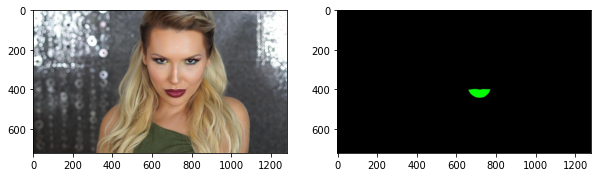

In [7]:
image_path = DATA_ROOT +'720p/'+ df['filename'].values[0]
mask_path  = DATA_ROOT +'mask/'+ df['mask'].values[0]

img = plt.imread(image_path)
mask = plt.imread(mask_path)

fig,ax = plt.subplots(1,2,figsize=(10,7))
ax[0].imshow(img)
ax[1].imshow(mask[..., :])
plt.show()

### 2. Выполним предобработку изображений в датасете.

Интересующие нас объекты, на всех изображения в предосталенном наборе данных, раполагаются поцентру изображения. Поэтому, можно спокойно отрезать по 200 pix с краев изображения.

Вот так.

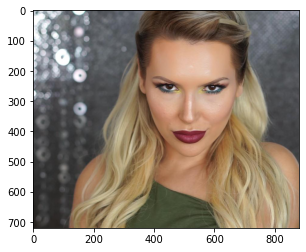

In [8]:
crop_img = img[0:720, 200:1280-200]
plt.imshow(crop_img)

Перд тем как подать изображение в нейронную сеть приведем изображения к размеру 256х256 pix. 
Проеведенная выше операция позволит избежать сильной деформации картинки, при изменении размера изображения.

In [9]:
IM_SIZE = (256,256)

Применим операцию по обрезке изображения с краев и уменьшения размера ко все изображениям из представленного набора данных. С тем чтобы не тратить время на ее выполнения во время обучения модели. 

После всех преобразований изображения будут сохранены в папки "image_resized" и "mask_resized". 

In [10]:
new_image_paths = []
new_mask_paths = []
image_path_resized = Path(DATA_ROOT+'image_resized')
Path.mkdir(image_path_resized, exist_ok=True)

mask_path_resized = Path(DATA_ROOT+'mask_resized')
Path.mkdir(mask_path_resized, exist_ok=True)

for index, row in tqdm(df.iterrows()):
    try: 
        im_path = Path(DATA_ROOT+'720p/'+row['filename'])
         # Проверим. существуетли файл. 
        im = cv2.imread(str(im_path))

        crop_img = im[0:720, 200:1280-200] # Кропаем изображение.
        im_resized = cv2.resize(crop_img, IM_SIZE)
        new_image_path = str(image_path_resized/im_path.parts[-1])

        cv2.imwrite(new_image_path, im_resized)

        mask_path = Path(DATA_ROOT+'mask/'+row['mask'])
        mask = cv2.imread(str(mask_path))

        crop_mask = mask[0:720, 200:1280-200]
        mask_resized = cv2.resize(crop_mask, IM_SIZE)
        new_mask_path = str(mask_path_resized/mask_path.parts[-1])

        cv2.imwrite(new_mask_path, mask_resized)

        new_image_paths.append(new_image_path)
        new_mask_paths.append(new_mask_path)
    except Exception as ex:
        print(index, ex)
    
df_resize = pd.DataFrame({'new_image':new_image_paths, 'new_mask':new_mask_paths})

10720it [06:02, 34.07it/s]10715 'NoneType' object is not subscriptable
10716 'NoneType' object is not subscriptable
10717 'NoneType' object is not subscriptable
10718 'NoneType' object is not subscriptable
10720 'NoneType' object is not subscriptable
10721 'NoneType' object is not subscriptable
10728it [06:02, 32.87it/s]10723 'NoneType' object is not subscriptable
10729 'NoneType' object is not subscriptable
10737it [06:03, 35.73it/s]10731 'NoneType' object is not subscriptable
10732 'NoneType' object is not subscriptable
10734 'NoneType' object is not subscriptable
10735 'NoneType' object is not subscriptable
10736 'NoneType' object is not subscriptable
10745it [06:03, 33.43it/s]10739 'NoneType' object is not subscriptable
10741 'NoneType' object is not subscriptable
10742 'NoneType' object is not subscriptable
10743 'NoneType' object is not subscriptable
10744 'NoneType' object is not subscriptable
10749it [06:03, 32.28it/s]10746 'NoneType' object is not subscriptable
10750 'NoneType

In [11]:
df_resize.head()

,new_image,new_mask
0,set-lipstick-original/image_resized/image00000...,set-lipstick-original/mask_resized/mask0000000...
1,set-lipstick-original/image_resized/image00000...,set-lipstick-original/mask_resized/mask0000000...
2,set-lipstick-original/image_resized/image00000...,set-lipstick-original/mask_resized/mask0000000...
3,set-lipstick-original/image_resized/image00000...,set-lipstick-original/mask_resized/mask0000000...
4,set-lipstick-original/image_resized/image00000...,set-lipstick-original/mask_resized/mask0000000...


некоторых изображений несуществует.

In [12]:
df.loc[(df['mask']=='mask00010813.png')]

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
10812,image00010813.jpg,1280,720,Lips,512,367,724,463,mask00010813.png


In [13]:
# Сохраним датасет в файл.

df_resize.to_csv(DATA_ROOT+'list_resized.csv')

In [10]:
# Востановим датасет из файла.

df_resize = pd.read_csv(DATA_ROOT+'list_resized.csv')

### 3. Обернем все в кастомный датасет для удобной работы в PyTorch.

Создадим класс для кастомного датасета:

In [11]:
class LipstickDataset(Dataset):
    def __init__(self, image_paths, mask_paths, preprocessing=None):
        self.image_paths = image_paths.values
        self.mask_paths = mask_paths.values
        self.preprocessing = preprocessing
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self,idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = cv2.imread(str(image_path)).astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.preprocessing:
            image = self.preprocessing(image).astype(np.float32)
        else:
            image = image / 255.0

        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask.astype(np.float32), cv2.COLOR_BGR2RGB)
        mask = mask[:,:,1]/255.0

        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)  

        return (image, mask)

In [12]:
dataset = LipstickDataset(df_resize['new_image'], df_resize['new_mask'])

Проверим корректность работы созданного класса.

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
tensor(0.) tensor(1.)


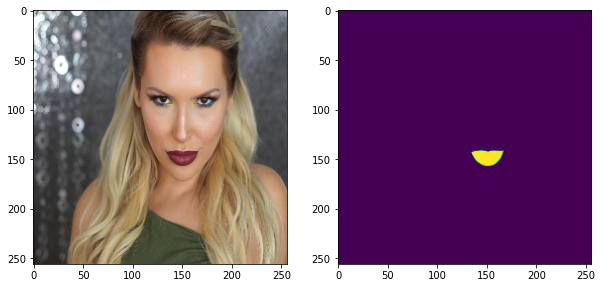

In [13]:
img, mask = dataset[0]
print(img.shape, mask.shape)
print(mask.min(), mask.max())

fig, ax = plt.subplots(1, 2, figsize=(10, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(mask.permute(1, 2, 0)[..., 0])
plt.show()

In [14]:
len(df_resize)

28540

Разобъем датасет на тренировочную, тестовую и валидационную выборки.  

In [15]:
df_train, df_test = train_test_split(df_resize, test_size=0.3,shuffle=True)

df_test, df_val = train_test_split(df_test, test_size=0.5,shuffle=True)

In [16]:
len(df_train), len(df_test), len(df_val)

(19978, 4281, 4281)

### 4. Настройка параметров модели.  

In [17]:
BACKBONE = 'vgg16'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['Lips']


segmodel = smp.Unet(encoder_name = BACKBONE, 
                       classes=len(CLASSES),
                       encoder_weights= ENCODER_WEIGHTS,
                       activation='sigmoid')

preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

In [18]:
train_data = LipstickDataset(df_train['new_image'], df_train['new_mask'], preprocessing= preprocess_input)
test_data = LipstickDataset(df_test['new_image'], df_test['new_mask'], preprocessing= preprocess_input)

val_data = LipstickDataset(df_val['new_image'], df_val['new_mask'], preprocessing= preprocess_input)

In [19]:
batch_size_train = 8
batch_size_test = 8
batch_size_val = 8

In [20]:
train_dl = DataLoader(
    train_data,
    batch_size = batch_size_train,
    shuffle=True
)
test_dl = DataLoader(
    test_data,
    batch_size = batch_size_test,
    shuffle=False
)
val_dl = DataLoader(
    val_data,
    batch_size = batch_size_val,
    shuffle=False
)

Проверим DataLoader.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])
tensor(0.) tensor(1.)


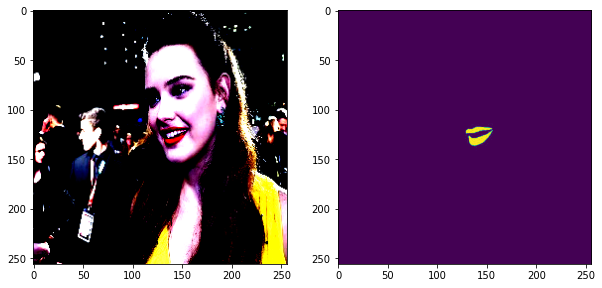

In [21]:
for img,mask in train_dl:
    break

print(img.shape)
print(mask.shape)
print(mask.min(), mask.max())

fig, ax = plt.subplots(1, 2, figsize=(10, 7))
ax[0].imshow(img[0].permute(1, 2, 0))
ax[1].imshow(mask[0].permute(1, 2, 0)[..., 0])
plt.show()

Подготовоительная работа завершена. Можно приступать к обучению модели. 

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [23]:
loss = smp.utils.losses.DiceLoss()

metrics = [smp.utils.metrics.IoU(threshold=0.3),]

optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

In [24]:
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

### 5. обучение модели.  

In [25]:
# train model
max_score = 0
epochs = 3
for i in range(epochs):
    print(f'Epoch: {i + 1}/{epochs}')
    train_logs = train_epoch.run(train_dl)
    valid_logs = valid_epoch.run(test_dl)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1/3
train:   0%|          | 0/2498 [00:00<?, ?it/s]/home/sergey/anaconda3/envs/imageai_env/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
valid: 100%|██████████| 536/536 [02:48<00:00,  3.19it/s, dice_loss - 0.06994, iou_score - 0.8747]
Model saved!
Epoch: 2/3
valid: 100%|██████████| 536/536 [02:30<00:00,  3.56it/s, dice_loss - 0.05219, iou_score - 0.9019]
Model saved!
Epoch: 3/3
valid: 100%|██████████| 536/536 [02:30<00:00,  3.56it/s, dice_loss - 0.04518, iou_score - 0.9137]
Model saved!


In [26]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

### 6. Проверим качетво на валидационном датасете.

In [27]:
valid_logs = valid_epoch.run(val_dl)

valid: 100%|██████████| 536/536 [02:50<00:00,  3.14it/s, dice_loss - 0.04475, iou_score - 0.9146]


In [28]:
for images,labels in val_dl:
    break

img = images.to(device)
mask = labels.to(device)
outputs = best_model(img)# load best saved checkpoint
best_model = torch.load('./best_model.pth')# load best saved checkpoint
best_model = torch.load('./best_model.pth')

outputs=outputs.to('cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


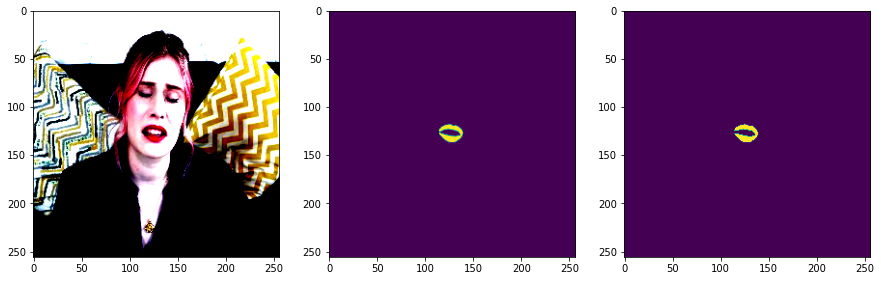

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


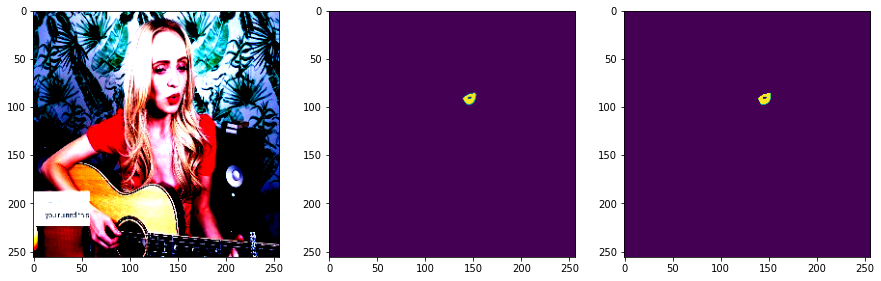

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


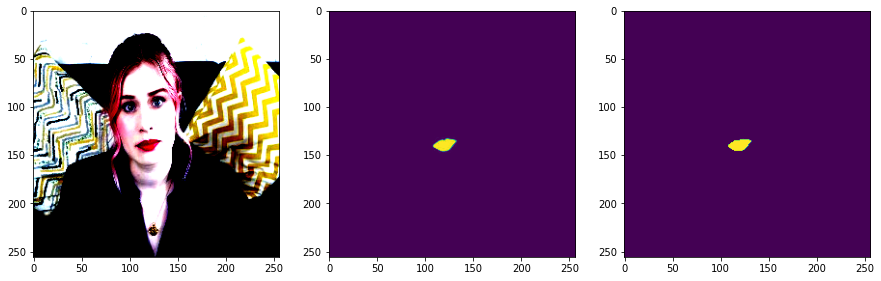

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


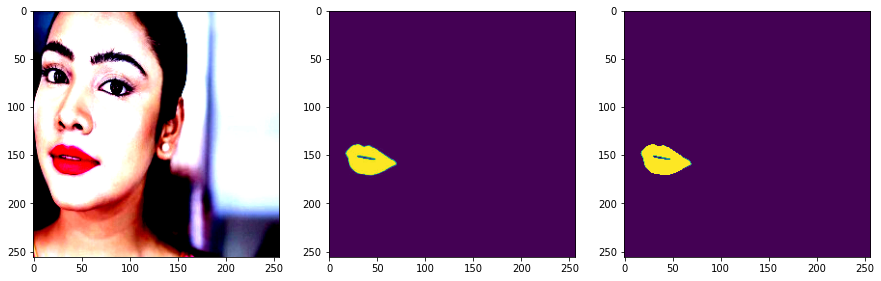

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


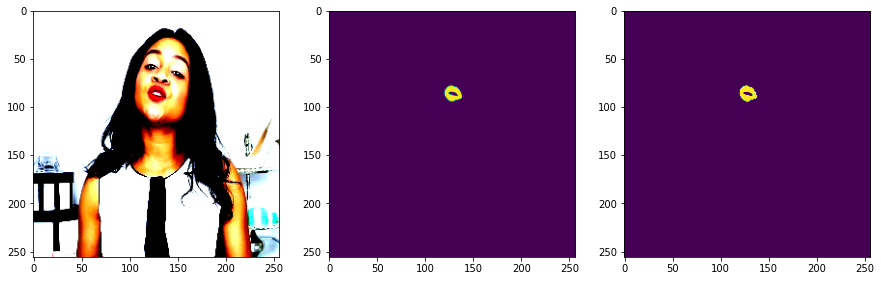

In [29]:
for i in range(5):
    fig, ax = plt.subplots(1, 3, figsize=(15, 7))
    ax[0].imshow(images[i].permute(1, 2, 0))
    ax[1].imshow(labels[i].permute(1, 2, 0))
    ax[2].imshow(outputs[i].permute(1, 2, 0).detach().numpy())
    plt.show()